This code is the first attempt at creating a transient model using rosenthal's solution to moving point heat sources. It models a point source that moves at a linear velocity. The equation used in this code can be seen in a report done by Jan Mehen et al.
$T(x,y)=\frac{Q(\rho{c})^{\frac{1}{2}}}{8(\pi{k}{t})^{\frac{3}{2}}}\cdot{e^{-\frac{\rho{c}}{4kt}[(x-x')^{2}+(y-y')^{2}]]}}$



There are no warnings written into this version, so inputs have to be correct for the code to function. Make sure the heat source starts on the plate and that all material properties are positive. The following inputs need to be integers: nx, ny, Data_Points, and Temp_Definition.

In [ ]:
%reset
import numpy as np
#import math as m
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
import seaborn as sns
# Input parameters:

# Plate Initialization:
x_length = .05;          # [m]
y_length = .05;          # [m]
nx = 100;                # number of grid points (Should be at least 1 per mm)
ny = 100;                # number of grid points

# Plate Properties:
T0 = 300; 			        # Initial ambient temperature [K]
q = 840; 			          # laser power [W]
k = 35; 			          # conductivity coefficient [W/m/K]
cp = 800; 			        # specific heat [J/kg/K]
rho = 7600.0; 		      # density [kg/m^3]

# Laser Initialization:
HSP =[0,0];       # Initial position of heat source from plate center (x,y) [m]
vx = -5/1000; 	        # laser speed x [m/s] (from [mm/sec])
vy = -5/1000; 	        # laser speed y [m/s]

# Simulation Options: 
Max_Time = 3;           # Time simulated [s]
Data_points = 400;      # amount of data sets collected
Frames_Used = 100;       # Frames seen (Should evenly devide Data points)
Scale = 1;              # figure window scale
Window_Pos = [0,0];     # Position of window from plate center (x,y) [m]
Temp_sensitivity = 100;  # pecent of maximum temperature shown on figure 
Temp_Definition  = 200; # Levels of temperature displayed on figure

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Mesh and figure creation: This is done outside the loop to decrease load on computiations. 

Loop that calcualtes heat transfer.

In [ ]:
[x,y] = np.meshgrid(np.linspace(-x_length/2,x_length/2,nx),np.linspace(-y_length/2,y_length/2,ny)); # [m]

Time = np.linspace(0,Max_Time,Data_points);
dt = Max_Time/Data_points;
T_pre = np.zeros((nx,ny)); T_diff =np.zeros((nx-1,ny-1));
T0_Mat = T0*np.ones((nx,ny));
T = T0*np.ones((nx,ny));
Trial_Temps =T0*np.ones((nx,ny));
for t in range(np.size(Time)):
  if t == 0:
    Trial_Temps =T0*np.ones((nx,ny));
  T_pre = T;
  for i in range(1,nx-1,1):
    for j in range(1,ny-1,1):     # gauss seidel iteration
      T_diff[i][j]=(T_pre[i][j]+k*(T[i-1][j]+T[i+1][j]+T[i][j-1]+T[i][j+1]))/(1+4*k);
            
  for i in range(1,nx-1,1):
    for j in range(1,ny-1,1):
      A = (rho*cp)**(1/2);
      B = 8*((np.pi*k*dt)**(3/2));
      C = (rho*cp)/(4*k*dt);
      D = ((x[i][j]-HSP[0])**2)+((y[i][j]-HSP[1]))**2;
      Q = q*dt; #Laser strength [J]
      T[i][j] = T_diff[i][j] + ((Q*A)/B)*np.exp(-C*D); 

  Trial_Temps = np.concatenate((Trial_Temps,T));
  
  HSP[0] = HSP[0]+vx*dt;
  HSP[1] = HSP[1]+vy*dt;

T_Max = np.max(np.max(Trial_Temps));

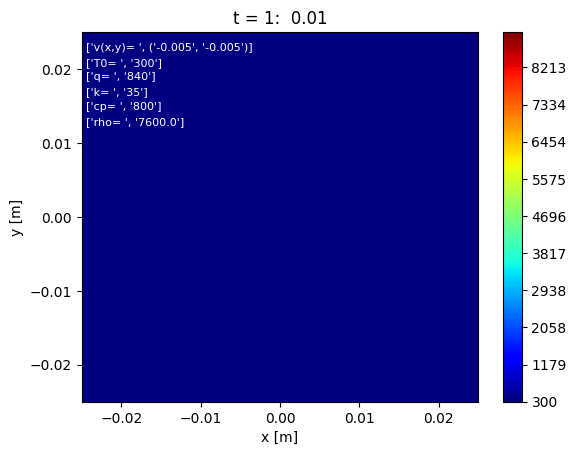

In [ ]:
fig = plt.figure()

plt.rcParams.update({'text.color': "Black"})
ax = plt.axes(xlim=((-((x_length/2)+Window_Pos[0])*Scale, ((x_length/2)+Window_Pos[0])*Scale)), ylim=((-((y_length/2)+Window_Pos[1])*Scale, ((y_length/2)+Window_Pos[1])*Scale)),xlabel='x [m]',ylabel='y [m]')
plt.rcParams.update({'text.color': "white"})
ax.text(0.01, 0.95,['v(x,y)= ', (str(vx),str(vy))], transform=ax.transAxes,fontsize=8);
ax.text(0.01, 0.91,['T0= ', str(T0)], transform=ax.transAxes,fontsize=8);
ax.text(0.01, 0.87,['q= ', str(q)], transform=ax.transAxes,fontsize=8);
ax.text(0.01, 0.83,['k= ', str(k)], transform=ax.transAxes,fontsize=8);
ax.text(0.01, 0.79,['cp= ', str(cp)], transform=ax.transAxes,fontsize=8);
ax.text(0.01, 0.75,['rho= ', str(rho)], transform=ax.transAxes,fontsize=8);
plt.rcParams.update({'text.color': "Black"})

cvals = np.linspace(T0,T_Max*(Temp_sensitivity/100),Temp_Definition)     # set contour values 
cont = plt.contourf(x, y, T0_Mat, cvals,cmap = cm.jet)    # first image on screen
plt.colorbar(cont)

n = int(Data_points/Frames_Used);
def Trial_Data(Frm):   # function returns a 2D data array
  global n
  return Trial_Temps[((n*Frm)*ny):((n*Frm)+1)*ny][:] 

# animation function
def animate(dp):
    global cont
    T_Array = Trial_Data(dp)
    for c in cont.collections:
        c.remove()  # removes only the contours, leaves the rest intact
    cont = plt.contourf(x, y, T_Array, cvals,cmap = cm.jet)
    plt.title('t = %i:  %.2f' % (dp+1,Time[int((n*dp)+1)]))
    return cont

anim = animation.FuncAnimation(fig, animate, frames=Frames_Used, repeat=False)
from IPython.display import HTML
HTML(anim.to_html5_video())
